# Imports

In [1]:
# !python -m spacy download nl_core_news_sm
# !python -m spacy download nl_core_news_md
# !python -m spacy download nl_core_news_lg

# !pip install spacy
# !pip install spacy[transformers]
# !pip install spacy-lookups-data

In [2]:
# to switch Spacy versions:

# !pip install spacy==2.3.9
# !pip install spacy==3.8.2

import spacy
print(f"Spacy version: {spacy.__version__}")

Spacy version: 3.8.2


In [3]:
# In case an uninstall is required:

# !pip uninstall -y spacy
# !python -m spacy.cli.remove-cache

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import spacy
import random
import spacy.training.loop
from spacy import displacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin, Doc
from spacy.training import Example
from spacy.training.loop import train
from spacy.training.example import Example
from spacy.training.initialize import init_nlp
from spacy.util import registry, minibatch
from pathlib import Path
from collections import Counter

In [5]:
import thinc
print(thinc.__version__)

8.3.2


# Visualize Spans

In [6]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

In [7]:
colors = {
    "Vastgoed": "#8bc34a",  # Green
    "Ondernemingen": "#2196f3",  # Blue
    "Arbeid": "#ffeb3b",  # Yellow
    "Aansprakelijkheid & Letselschade": "#f44336",  # Red
}

In [8]:
options = {
    "spans_key": "sc",  # Adjust if your span key is different
    "colors": colors
}

displacy.render(docs[0], style="span", options=options, jupyter=True)

In [9]:
for i, doc in enumerate(docs[:5]):
    print(f"\nDoc {i+1}:")
    displacy.render(doc, style="span", options=options, jupyter=True)


Doc 1:



Doc 2:



Doc 3:



Doc 4:



Doc 5:


# Training SpanCat Model

This is our initial implementation, we use no testing set yet, we only train and validate to see if we get a functional model

In [10]:
# Add the spancat component
spancat = nlp.add_pipe("spancat", config={"spans_key": "sc"}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

1

In [11]:
# Reload training data
doc_bin = spacy.tokens.DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle and split
random.shuffle(train_data)
split = int(len(train_data) * 0.8)
train_examples = train_data[:split]
dev_examples = train_data[split:] # This is the validation set, in NLP this set is refered to as the development set

In [12]:
# Start training
nlp.begin_training()
train(nlp, train_examples, dev_examples, n_iter=10)  # Train for 10 iterations

# Save trained model
nlp.to_disk("output_spancat_lg")

TypeError: train() got an unexpected keyword argument 'n_iter'

In [13]:
# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 10

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/10
Losses: {'tok2vec': 1220.7813847661018, 'morphologizer': 38049.978286743164, 'tagger': 38763.95851135254, 'parser': 54790.68990325928, 'lemmatizer': 39094.75476074219, 'ner': 0.0, 'spancat': 22608.18000793457}
Epoch 2/10
Losses: {'tok2vec': 2583.8853815197945, 'morphologizer': 35934.77713012695, 'tagger': 36884.43135070801, 'parser': 50757.25750350952, 'lemmatizer': 24860.333857536316, 'ner': 0.0, 'spancat': 308.6923656463623}
Epoch 3/10
Losses: {'tok2vec': 2119.6468755254064, 'morphologizer': 34271.61241149902, 'tagger': 34893.637619018555, 'parser': 44697.6824092865, 'lemmatizer': 157.569598800299, 'ner': 0.0, 'spancat': 308.4513530731201}
Epoch 4/10
Losses: {'tok2vec': 2194.8044261638343, 'morphologizer': 30218.578674316406, 'tagger': 31512.440216064453, 'parser': 40987.55151176453, 'lemmatizer': 0.4148046058971886, 'ner': 0.0, 'spancat': 307.9461078643799}
Epoch 5/10
Losses: {'tok2vec': 2820.7224880448184, 'morphologizer': 23623.011726379395, 'tagger': 25031.334266662598

The model above does not seem to yield any predictions.

# Plotting Span Length Frequency

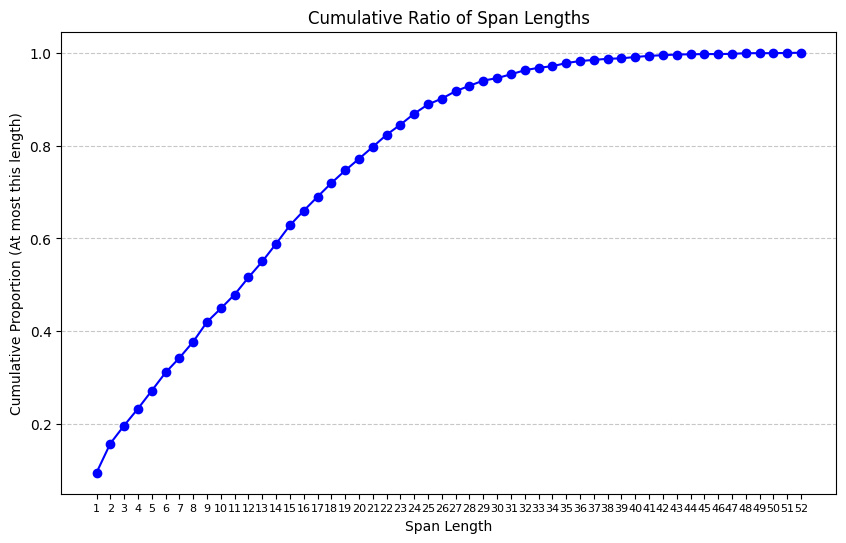

In [10]:
#Obtain the frequency per span length
span_lengths = []
for doc in docs:
    for span in doc.spans.get("sc", []):
        span_lengths.append(len(span))
span_length_counts = np.bincount(span_lengths, minlength=max(span_lengths) + 1)

# Calculate the cumulative sum
cumulative_counts = np.cumsum(span_length_counts)

# Convert to ratio
total_spans = len(span_lengths)
cumulative_ratio = cumulative_counts / total_spans

# Plot cumulative ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_ratio)), cumulative_ratio[1:], marker='o', linestyle='-', color='b')
plt.xlabel('Span Length')
plt.ylabel('Cumulative Proportion (At most this length)')
plt.title('Cumulative Ratio of Span Lengths')
plt.xticks(range(1, max(span_lengths) + 1), fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.9
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.9: 26


# Including Test Set & Ngram

Now that we confirmed that the training code works, we keep 15\% of the data for testing purpuses

In [20]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "suggester": {
        "@misc": "spacy.ngram_suggester.v1",
        "sizes": [i for i in range(1,27)]},
    "threshold": 0.05  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 50

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/50
Losses: {'tok2vec': 915.5817851237953, 'morphologizer': 33518.92677307129, 'tagger': 34079.44383239746, 'parser': 49254.768030166626, 'lemmatizer': 34332.114028930664, 'ner': 0.0, 'spancat': 283001.32720947266}
Epoch 2/50
Losses: {'tok2vec': 3494.088406085968, 'morphologizer': 31665.909240722656, 'tagger': 32400.434310913086, 'parser': 50460.0469353199, 'lemmatizer': 21344.74051094055, 'ner': 0.0, 'spancat': 1313.8564739227295}
Epoch 3/50
Losses: {'tok2vec': 2176.462367918808, 'morphologizer': 30551.483642578125, 'tagger': 31047.867904663086, 'parser': 38746.04941636324, 'lemmatizer': 255.55895300768316, 'ner': 0.0, 'spancat': 1312.8557033538818}
Epoch 4/50
Losses: {'tok2vec': 2758.2875319503955, 'morphologizer': 27972.292205810547, 'tagger': 28744.805068969727, 'parser': 39452.321108818054, 'lemmatizer': 3.536537213023621, 'ner': 0.0, 'spancat': 1311.2333183288574}
Epoch 5/50
Losses: {'tok2vec': 2328.220440481822, 'morphologizer': 22863.80104827881, 'tagger': 23836.50739288

In [21]:
# Pick a test example
example = test_examples[0]

# Use the test example's reference doc
doc = example.reference

# Convert text to new doc via tokenizer (if not already done)
doc = nlp.make_doc(doc.text)

# Run the pipeline up to the spancat component
predictions = nlp.get_pipe("spancat").predict([doc])

# Set annotations on the doc based on those predictions
nlp.get_pipe("spancat").set_annotations([doc], predictions)

# Now get the scored spans
spans = doc.spans["sc"]

# Unfortunately, span.score isn't available, but we can get scores manually
# via the Spancat’s predict method, which returns scores for candidate spans

# Example: get the predicted scores for spans in the doc
scores = nlp.get_pipe("spancat").predict([doc])[0]  # just one doc here
# print(scores.keys())
print(scores)

Ragged(data=array([[   0,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [1277, 1303],
       [1278, 1304],
       [1279, 1305]]), lengths=array([33605]), data_shape=(-1, 2), starts_ends=None)


In [22]:
def print_span_predictions(nlp, text, spans_key="sc"):
    doc = nlp.make_doc(text)
    spancat = nlp.get_pipe("spancat")
    predictions = spancat.predict([doc])
    spancat.set_annotations([doc], predictions)
    
    labels = spancat.labels
    pred_spans = predictions[0].data.tolist()
    pred_scores = predictions[1].data.tolist()
    
    for (start, end), span_scores in zip(pred_spans, pred_scores):
        span_text = doc[start:end].text
        for label, score in zip(labels, span_scores):
            print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

# Example usage:
example = test_examples[0]
print_span_predictions(nlp, example.reference.text)

Span: 'Zorg-zzp', Label: Vastgoed, Score: 0.009
Span: 'Zorg-zzp', Label: Ondernemingen, Score: 0.017
Span: 'Zorg-zzp', Label: Arbeid, Score: 0.008
Span: 'Zorg-zzp', Label: Aansprakelijkheid & Letselschade, Score: 0.278
Span: '’', Label: Vastgoed, Score: 0.000
Span: '’', Label: Ondernemingen, Score: 0.071
Span: '’', Label: Arbeid, Score: 0.000
Span: '’', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'ers', Label: Vastgoed, Score: 0.000
Span: 'ers', Label: Ondernemingen, Score: 0.001
Span: 'ers', Label: Arbeid, Score: 0.000
Span: 'ers', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'willen', Label: Vastgoed, Score: 0.000
Span: 'willen', Label: Ondernemingen, Score: 0.000
Span: 'willen', Label: Arbeid, Score: 0.000
Span: 'willen', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'duidelijkheid', Label: Vastgoed, Score: 0.000
Span: 'duidelijkheid', Label: Ondernemingen, Score: 0.000
Span: 'duidelijkheid', Label: Arbeid, Score: 0.000
Span: 'duidelijkhe

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [23]:
# Visualize the spans in the test document
for test_doc in test_examples[0]:  # Use the first test example for visualization
    pred_doc = nlp(test_doc.text)  # Run model on raw text
    displacy.render(pred_doc, style="span", page=True)

TypeError: 'spacy.training.example.Example' object is not iterable

In [24]:
pred_doc = nlp(test_examples[0].text)  # Run model on raw text
displacy.render(pred_doc, style="span", page=True)

C:\Users\20193204\AppData\Local\Continuum\anaconda3\envs\Thesis\lib\site-packages\spacy\pipeline\attributeruler.py:149: UserWarning: [W036] The component 'matcher' does not have any patterns defined.
  matches = self.matcher(doc, allow_missing=True, as_spans=False)


In [25]:
# performance

def evaluate_spancat(nlp, examples, threshold=0.05, spans_key="sc"):
    spancat = nlp.get_pipe("spancat")
    labels = spancat.labels
    
    total_tp, total_fp, total_fn = 0, 0, 0
    overlap_scores = []
    
    for ex in examples:
        doc = ex.predicted
        gold_doc = ex.reference

        # Predict spans for the doc
        predictions = spancat.predict([doc])
        pred_spans = predictions[0].data.tolist()
        pred_scores = predictions[1].data.tolist()

        pred_spans_with_labels = []
        for (start, end), scores in zip(pred_spans, pred_scores):
            for label, score in zip(labels, scores):
                if score >= threshold:
                    pred_spans_with_labels.append((start, end, label))

        # Gold spans
        gold_spans_with_labels = [(span.start, span.end, span.label_) for span in gold_doc.spans.get(spans_key, [])]

        # F1 components
        tp = 0
        matched_golds = set()

        for ps in pred_spans_with_labels:
            if ps in gold_spans_with_labels:
                tp += 1
                matched_golds.add(ps)
        
        fp = len(pred_spans_with_labels) - tp
        fn = len(gold_spans_with_labels) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Overlap score per predicted span
        for ps in pred_spans_with_labels:
            best_overlap = 0
            for gs in gold_spans_with_labels:
                if ps[2] != gs[2]:  # labels don't match
                    continue
                pred_start, pred_end = ps[0], ps[1]
                gold_start, gold_end = gs[0], gs[1]
                overlap = max(0, min(pred_end, gold_end) - max(pred_start, gold_start))
                union = max(pred_end, gold_end) - min(pred_start, gold_start)
                overlap_ratio = overlap / union if union > 0 else 0
                if overlap_ratio > best_overlap:
                    best_overlap = overlap_ratio
            overlap_scores.append(best_overlap)

    # Precision, Recall, F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Average overlap score
    avg_overlap_score = sum(overlap_scores) / len(overlap_scores) if overlap_scores else 0.0

    return {"precision": precision, "recall": recall, "f1": f1, "avg_overlap_score": avg_overlap_score}

In [26]:
print(evaluate_spancat(nlp, test_examples, threshold=0.05))

{'precision': 0.1518324607329843, 'recall': 0.09006211180124224, 'f1': 0.11306042884990254, 'avg_overlap_score': 0.20133418942725403}


Find best: <br>

- Number of epochs to avoid overfitting
- n value (for ngrams), check if you can exclude length 1
- best decision threshold
- nl_core_news_lg vs nl_core_news_md

Do this by calculating performance (maybe changed to modified F1 instead of modified precision) on validation set (called development set in NLP) and selecting the best one

Make seperate training folder and model for each class so domain expert feedback can be given for a single class

# Finding confidence per span

In [16]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

# Add the spancat component
spancat = nlp.add_pipe("spancat", config={
    "spans_key": "sc",
    "threshold": 0.2  # You can still set the threshold for span categorization
}, last=True)

# Define the 4 labels
spancat.add_label("Vastgoed")
spancat.add_label("Ondernemingen")
spancat.add_label("Arbeid")
spancat.add_label("Aansprakelijkheid & Letselschade")

# Save the config (optional)
nlp.config.to_disk("config.cfg")

# Create Example objects directly from the docs
train_data = [Example(d, d) for d in docs]

# Shuffle all examples
random.seed(3479220)
random.shuffle(train_data)

# Calculate split points
total = len(train_data)
train_split = int(total * 0.7)
dev_split = int(total * 0.85)

# Split data
train_examples = train_data[:train_split]
dev_examples = train_data[train_split:dev_split]
test_examples = train_data[dev_split:]

# Initialize the model
optimizer = nlp.initialize()

# Number of training iterations (epochs)
n_iter = 10

# Training loop
for i in range(n_iter):
    print(f"Epoch {i+1}/{n_iter}")
    random.shuffle(train_examples)
    losses = {}

    # Use minibatch training for efficiency
    from spacy.util import minibatch
    batches = minibatch(train_examples, size=8)
    for batch in batches:
        nlp.update(batch, sgd=optimizer, losses=losses)

    print(f"Losses: {losses}")

# Save the trained model to a specific directory
output_dir = "output_spancat_lg"
nlp.to_disk(output_dir)

Epoch 1/10
Losses: {'tok2vec': 795.4983920790255, 'morphologizer': 33525.149993896484, 'tagger': 34088.26768493652, 'parser': 51683.35157203674, 'lemmatizer': 34341.92803955078, 'ner': 0.0, 'spancat': 38512.316162109375}
Epoch 2/10
Losses: {'tok2vec': 4340.292999505997, 'morphologizer': 31536.90414428711, 'tagger': 32328.53302001953, 'parser': 52031.73078298569, 'lemmatizer': 22842.879806518555, 'ner': 0.0, 'spancat': 288.70452976226807}
Epoch 3/10
Losses: {'tok2vec': 1847.0384680945426, 'morphologizer': 30256.705780029297, 'tagger': 30879.71551513672, 'parser': 38279.191740214825, 'lemmatizer': 348.0657969750464, 'ner': 0.0, 'spancat': 288.36766266822815}
Epoch 4/10
Losses: {'tok2vec': 2481.6823935453385, 'morphologizer': 26867.295852661133, 'tagger': 27834.2452545166, 'parser': 37720.56346654892, 'lemmatizer': 4.191095176829549, 'ner': 0.0, 'spancat': 287.4346251487732}
Epoch 5/10
Losses: {'tok2vec': 3144.884949617932, 'morphologizer': 21492.306060791016, 'tagger': 22686.606155395508

In [48]:
# Pick a test example
example = test_examples[0]

# Use the test example's reference doc
doc = example.reference

# Convert text to new doc via tokenizer (if not already done)
doc = nlp.make_doc(doc.text)

# Run the pipeline up to the spancat component
predictions = nlp.get_pipe("spancat").predict([doc])

# Set annotations on the doc based on those predictions
nlp.get_pipe("spancat").set_annotations([doc], predictions)

# Now get the scored spans
spans = doc.spans["sc"]

# Unfortunately, span.score isn't available, but we can get scores manually
# via the Spancat’s predict method, which returns scores for candidate spans

# Example: get the predicted scores for spans in the doc
scores = nlp.get_pipe("spancat").predict([doc])[0]  # just one doc here
# print(scores.keys())
print(scores)

Ragged(data=array([[   0,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [1300, 1303],
       [1301, 1304],
       [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=None)


In [45]:
nlp.get_pipe("spancat").predict([doc])

(Ragged(data=array([[   0,    1],
        [   1,    2],
        [   2,    3],
        ...,
        [1300, 1303],
        [1301, 1304],
        [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=None),
 array([[1.5507017e-04, 6.4865932e-02, 8.4666644e-05, 1.6447941e-04],
        [3.5932771e-04, 2.6824868e-03, 1.2058189e-04, 1.3446168e-04],
        [2.8597016e-04, 1.7409291e-03, 1.9577135e-04, 2.1085711e-04],
        ...,
        [2.2239027e-04, 6.6113234e-03, 1.0821175e-04, 1.3718632e-04],
        [3.3788182e-04, 2.4922439e-03, 9.2018890e-05, 1.7754915e-04],
        [2.1568601e-04, 3.2733686e-03, 9.9428551e-05, 1.8704669e-04]],
       dtype=float32))

In [52]:
# Get your test doc text
example = test_examples[0]
text = example.reference.text
doc = nlp.make_doc(text)

# Predict spans and scores
spancat = nlp.get_pipe("spancat")
predictions = spancat.predict([doc])

# Set predicted annotations (populates doc.spans["sc"])
spancat.set_annotations([doc], predictions)

# Labels and scores
labels = spancat.labels
spans = predictions[0]["spans"]
score_values = predictions[0]["scores"]

# Map scores to spans
for (start, end), span_scores in zip(spans, score_values):
    span_text = doc[start:end].text
    for label, score in zip(labels, span_scores):
        print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

ValueError: invalid literal for int() with base 10: 's'

In [53]:
predictions

(Ragged(data=array([[   0,    1],
        [   1,    2],
        [   2,    3],
        ...,
        [1300, 1303],
        [1301, 1304],
        [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=array([   0, 3912], dtype=int32)),
 array([[1.5507017e-04, 6.4865932e-02, 8.4666644e-05, 1.6447941e-04],
        [3.5932771e-04, 2.6824868e-03, 1.2058189e-04, 1.3446168e-04],
        [2.8597016e-04, 1.7409291e-03, 1.9577135e-04, 2.1085711e-04],
        ...,
        [2.2239027e-04, 6.6113234e-03, 1.0821175e-04, 1.3718632e-04],
        [3.3788182e-04, 2.4922439e-03, 9.2018890e-05, 1.7754915e-04],
        [2.1568601e-04, 3.2733686e-03, 9.9428551e-05, 1.8704669e-04]],
       dtype=float32))

In [69]:
print(predictions[0])

Ragged(data=array([[   0,    1],
       [   1,    2],
       [   2,    3],
       ...,
       [1300, 1303],
       [1301, 1304],
       [1302, 1305]]), lengths=array([3912]), data_shape=(-1, 2), starts_ends=array([   0, 3912], dtype=int32))


In [72]:
# Get predicted spans and scores
pred_spans = predictions[0].data.tolist()  # (n_spans, 2)
pred_scores = predictions[1].data.tolist()  # (n_spans, n_labels)

In [74]:
pred_scores

[[0.00015507017087657005,
  0.06486593186855316,
  8.466664439765736e-05,
  0.0001644794101594016],
 [0.00035932770697399974,
  0.002682486781850457,
  0.00012058189167873934,
  0.00013446167577058077],
 [0.00028597016353160143,
  0.0017409290885552764,
  0.0001957713539013639,
  0.0002108571061398834],
 [0.0003181426727678627,
  0.006025577895343304,
  8.626907947473228e-05,
  0.0001812636764952913],
 [0.00016878756287042052,
  0.020900174975395203,
  0.00014048186130821705,
  0.00013303520972840488],
 [0.00021730849402956665,
  0.012465210631489754,
  9.14146366994828e-05,
  0.00014714806457050145],
 [0.00021538310102187097,
  0.011088560335338116,
  0.00011836925841635093,
  0.00013006133667659014],
 [0.00036958642886020243,
  0.001013587461784482,
  0.00021062239829916507,
  0.00028011322137899697],
 [0.00019460722978692502,
  0.005502910353243351,
  0.00013687364116776735,
  0.0001615043729543686],
 [0.000137577488203533,
  0.016466183587908745,
  0.00011173051461810246,
  0.00014

In [76]:
def print_span_predictions(nlp, text, spans_key="sc"):
    doc = nlp.make_doc(text)
    spancat = nlp.get_pipe("spancat")
    predictions = spancat.predict([doc])
    spancat.set_annotations([doc], predictions)
    
    labels = spancat.labels
    pred_spans = predictions[0].data.tolist()
    pred_scores = predictions[1].data.tolist()
    
    for (start, end), span_scores in zip(pred_spans, pred_scores):
        span_text = doc[start:end].text
        for label, score in zip(labels, span_scores):
            print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

# Example usage:
print_span_predictions(nlp, example.reference.text)

Span: 'Zorg-zzp', Label: Vastgoed, Score: 0.000
Span: 'Zorg-zzp', Label: Ondernemingen, Score: 0.065
Span: 'Zorg-zzp', Label: Arbeid, Score: 0.000
Span: 'Zorg-zzp', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: '’', Label: Vastgoed, Score: 0.000
Span: '’', Label: Ondernemingen, Score: 0.003
Span: '’', Label: Arbeid, Score: 0.000
Span: '’', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'ers', Label: Vastgoed, Score: 0.000
Span: 'ers', Label: Ondernemingen, Score: 0.002
Span: 'ers', Label: Arbeid, Score: 0.000
Span: 'ers', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'willen', Label: Vastgoed, Score: 0.000
Span: 'willen', Label: Ondernemingen, Score: 0.006
Span: 'willen', Label: Arbeid, Score: 0.000
Span: 'willen', Label: Aansprakelijkheid & Letselschade, Score: 0.000
Span: 'duidelijkheid', Label: Vastgoed, Score: 0.000
Span: 'duidelijkheid', Label: Ondernemingen, Score: 0.021
Span: 'duidelijkheid', Label: Arbeid, Score: 0.000
Span: 'duidelijkhe

In [18]:
print(evaluate_spancat(nlp, test_examples, threshold=0.05))

{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'avg_overlap_score': 0.0732281284606866}


Ideas: <br>
Gradually increasing batch size